In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import cv2
import io
from typing import List, Tuple
import pandas as pd
import scipy
from scipy import spatial
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
import scipy.linalg
import networkx as nx
import seaborn as sns
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.FCMBased import lingam 
from causallearn.utils.GraphUtils import GraphUtils
import graphviz
import warnings
warnings.filterwarnings('ignore')
import utils.nn_helper as helper
nn_helper = helper.NNHelper()

In [11]:
def find_arrow_heads(G) -> List[Tuple[int, int]]:
    """Return the list of i o-> j in adjmat as (i, j)"""
    L = np.where(G.graph == 1)
    return list(zip(L[1], L[0]))

def find_tails(G) -> List[Tuple[int, int]]:
    """Return the list of i --o j in adjmat as (j, i)"""
    L = np.where(G.graph == -1)
    return list(zip(L[1], L[0]))

def find_undirected(G) -> List[Tuple[int, int]]:
    """Return the list of undirected edge i --- j in adjmat as (i, j) [with symmetry]"""
    return [(edge[0], edge[1]) for edge in find_tails(G) if G.graph[edge[0], edge[1]] == -1]

def find_fully_directed(G) -> List[Tuple[int, int]]:
    """Return the list of directed edges i --> j in adjmat as (i, j)"""
    return [(edge[0], edge[1]) for edge in find_arrow_heads(G) if G.graph[edge[0], edge[1]] == -1]

def find_bi_directed(G) -> List[Tuple[int, int]]:
    """Return the list of bidirected edges i <-> j in adjmat as (i, j) [with symmetry]"""
    return [(edge[1], edge[0]) for edge in find_arrow_heads(G) if (
            G.graph[edge[1], edge[0]] == Endpoint.ARROW.value and G.graph[
        edge[0], edge[1]] == Endpoint.ARROW.value)]

def to_nx_graph(G):
    """Convert adjmat into a networkx.Digraph object named nx_graph"""
    nodes = range(len(G.graph))
    nx_graph = nx.DiGraph()  # store the directed graph
    labels = {i: G.nodes[i].get_name() for i in nodes}
    nx_graph.add_nodes_from(nodes)
    undirected = find_undirected(G)
    directed = find_fully_directed(G)
    bidirected = find_bi_directed(G)
    for (i, j) in undirected:
        nx_graph.add_edge(i, j, color='g')  # Green edge: undirected edge
    for (i, j) in directed:
        nx_graph.add_edge(i, j, color='b')  # Blue edge: directed edge
    for (i, j) in bidirected:
        nx_graph.add_edge(i, j, color='r')  # Red edge: bidirected edge
    return nx_graph

In [4]:
df = pd.read_csv('./data/post_manip_data/data_0_0.csv')
x_cols = [i for i in df.columns if ('x' in i) and (i!="com_x1")]
y_cols = [i for i in df.columns if 'y' in i  and (i!="com_y1")]
# data = df[['com_x1', 'com_x2', "com_y1", "com_y2"]]
X = 1000*df[x_cols].to_numpy() #[:2000]
Y = 1000*df[y_cols].to_numpy() #[:2000]
XY = np.hstack((X,Y))
X.shape, Y.shape, XY.shape

((13341, 65), (13341, 65), (13341, 130))

In [5]:
df

,com_x1,com_y1,com_x2,com_y2,robotx_0,robotx_1,robotx_2,robotx_3,robotx_4,robotx_5,...,roboty_54,roboty_55,roboty_56,roboty_57,roboty_58,roboty_59,roboty_60,roboty_61,roboty_62,roboty_63
0,0.132,-0.179,0.145031,-0.175735,0.006128,-0.021281,-0.012758,0.005676,0.004394,-0.010403,...,0.010370,-0.008148,0.018526,-0.024225,0.009802,-0.002404,0.004859,-0.005269,0.005633,0.010934
1,0.132,-0.179,0.132072,-0.178249,0.013705,-0.013871,-0.012365,0.014974,0.007526,-0.014451,...,0.015937,-0.006803,0.003849,-0.017648,-0.007534,-0.002068,0.022325,-0.023957,-0.024969,-0.023851
2,0.132,-0.179,0.130879,-0.171041,0.002477,-0.020383,0.021718,0.021087,-0.007863,0.015809,...,-0.006208,0.021021,-0.001730,0.009952,-0.001004,0.011139,0.004831,0.003861,0.021360,-0.009109
3,0.132,-0.179,0.131155,-0.178806,-0.019131,-0.014217,-0.011900,-0.006429,-0.014145,0.008239,...,0.015433,-0.003323,-0.000544,0.018418,0.006122,-0.005836,0.006270,0.018730,0.014710,-0.015017
4,0.132,-0.179,0.132284,-0.182869,-0.010738,0.015418,0.019875,0.008398,-0.018251,-0.001135,...,-0.008245,-0.024786,-0.010064,0.008035,0.020462,-0.014799,-0.016672,-0.009668,0.016695,0.020593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336,0.132,-0.179,0.135347,-0.186932,-0.012629,0.022998,0.012870,0.001264,0.006558,0.003296,...,0.021550,0.018001,-0.009017,-0.010866,-0.012044,0.016380,0.012389,0.001661,-0.008819,0.001146
13337,0.132,-0.179,0.121866,-0.192647,0.009141,0.006296,-0.012728,-0.008832,0.020416,-0.002056,...,-0.009736,-0.021625,-0.002801,-0.015275,-0.014503,-0.012318,0.007284,-0.023379,-0.020398,-0.005814
13338,0.132,-0.179,0.125639,-0.173184,0.009373,-0.010957,0.017764,0.002895,0.012111,-0.006242,...,0.001772,0.009997,-0.022355,0.010588,-0.024837,0.019941,0.024125,0.005593,-0.010395,-0.008802
13339,0.132,-0.179,0.132518,-0.178668,-0.015975,-0.016913,0.011745,0.007920,-0.019220,0.001322,...,0.021686,-0.019712,-0.001662,-0.003219,0.008236,0.017444,0.020332,0.014642,-0.006295,-0.011749


In [55]:
""" GES """
Record = ges(XY)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [

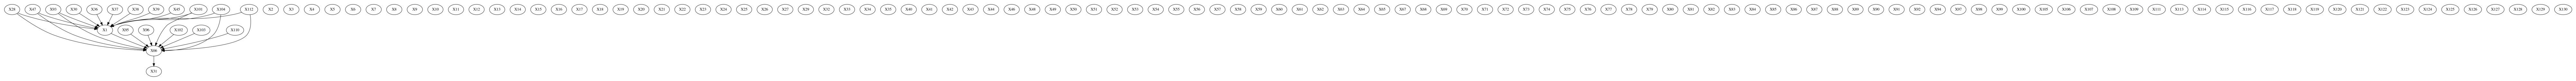

In [56]:
# Record = ges(X)
pyd = GraphUtils.to_pydot(Record['G'])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize=(150, 3))
plt.axis('off')
plt.imshow(img)
plt.show()

In [9]:
a = np.array([28,30,36,37,38,39, 45, 47])
a -= 1
b = np.array([93, 101, 104, 112, 95, 96, 102, 103, 110])
b -= 66
c = np.union1d(a, b)
np.vstack((a//8, a%8)), np.vstack((b//8, b%8)), np.vstack((c//8, c%8)).T

(array([[3, 3, 4, 4, 4, 4, 5, 5],
        [3, 5, 3, 4, 5, 6, 4, 6]]),
 array([[3, 4, 4, 5, 3, 3, 4, 4, 5],
        [3, 3, 6, 6, 5, 6, 4, 5, 4]]),
 array([[3, 3],
        [3, 5],
        [3, 6],
        [4, 3],
        [4, 4],
        [4, 5],
        [4, 6],
        [5, 4],
        [5, 6]]))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
backward


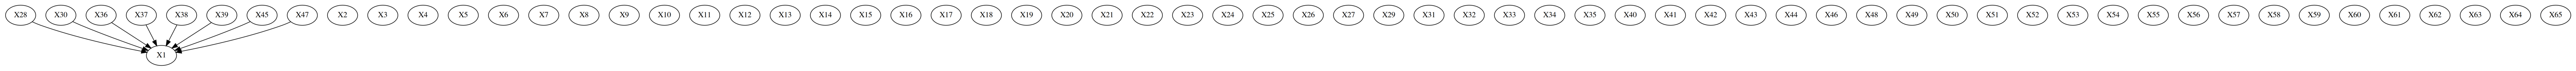

In [6]:
Record2 = ges(X)
pyd = GraphUtils.to_pydot(Record2['G'])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize=(100, 3))
plt.axis('off')
plt.imshow(img)
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [

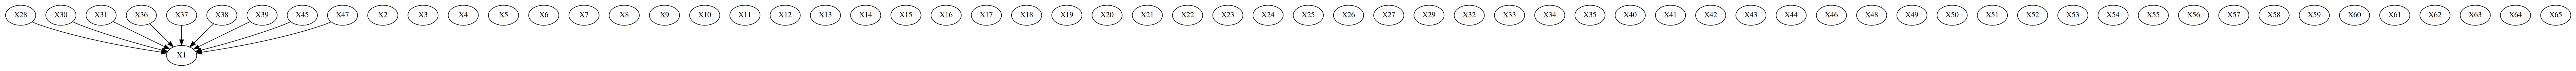

In [7]:
Record2 = ges(Y)
pyd = GraphUtils.to_pydot(Record2['G'])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize=(100, 3))
plt.axis('off')
plt.imshow(img)
plt.show()

In [36]:
# GES Neighborhood
a = np.array([26,34,35,37,43,45])
b = np.array([26,28,29,34,37,43,45])
np.vstack((a//8, a%8)), np.vstack((b//8, b%8))

(array([[3, 4, 4, 4, 5, 5],
        [2, 2, 3, 5, 3, 5]]),
 array([[3, 3, 3, 4, 4, 5, 5],
        [2, 4, 5, 2, 5, 3, 5]]))

In [58]:
""" PC """
cg = pc(X, 0.00005, 'fisherz')
cg.to_nx_graph()
nn_helper.draw_plain_graph(cg.nx_graph, scale=3)
cg = pc(Y, 0.00005, 'fisherz')
cg.to_nx_graph()
nn_helper.draw_plain_graph(cg.nx_graph, scale=3)

  0%|          | 0/65 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
G = Record['G']

In [24]:
# cg, edges = fci(Y, 'fisherz', 0.00005)
nn_helper.draw_plain_graph(to_nx_graph(G), scale=3)
plt.show()

NameError: name 'Endpoint' is not defined